In [1]:
import os
from dotenv import load_dotenv

In [2]:
# Define the path to the .env file (one directory above)
dotenv_path = '.env'

# Load the .env file
load_dotenv(dotenv_path)

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')
langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = langsmith_api_key
os.environ['OPENAI_API_KEY'] = openai_api_key

In [23]:
# Set up the tool
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def play_song_on_spotify(song: str):
    """Play a song on Spotify"""
    # Call the spotify API ...
    return f"Successfully played {song} on Spotify!"


@tool
def play_song_on_apple(song: str):
    """Play a song on Apple Music"""
    # Call the apple music API ...
    return f"Successfully played {song} on Apple Music!"


tools = [play_song_on_apple, play_song_on_spotify]
tool_node = ToolNode(tools)

# Set up the model

model = ChatOpenAI(model="gpt-4o-mini")
model = model.bind_tools(tools, parallel_tool_calls=False)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    print("Printing model response:")
    print(response)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory)

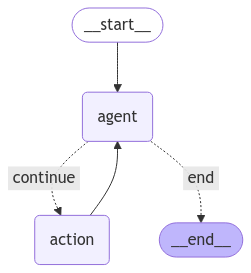

In [24]:
app

In [25]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Can you play Taylor Swift's most popular song on Apple Music?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    print("ended iteration")

================================ Human Message =================================

Can you play Taylor Swift's most popular song on Apple Music?
ended iteration
Printing model response:
content='' additional_kwargs={'tool_calls': [{'id': 'call_GQNiyZ3GqpTKYsM8D2SJBEuT', 'function': {'arguments': '{"song":"Blank Space by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 83, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-c8e15aec-8bf3-4a1e-ba3b-fa10f083d654-0' tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Blank Space by Taylor Swift'}, 'id': 'call_GQNi

In [15]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="What is the meaning of life")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the meaning of life
Printing model response:
content='The meaning of life is a philosophical question that has been contemplated by thinkers, theologians, and individuals throughout history. Different cultures, religions, and philosophies offer various interpretations:\n\n1. **Existentialism**: Suggests that life has no inherent meaning, and it’s up to each individual to create their own purpose through choices and actions.\n\n2. **Religious Perspectives**: Many religions propose that the meaning of life is connected to a relationship with the divine, moral living, and preparation for an afterlife.\n\n3. **Humanism**: Emphasizes the value of human beings and suggests that meaning can be found through relationships, personal growth, and contributions to society.\n\n4. **Biological Perspective**: From a scientific viewpoint, the meaning of life can be seen as survival and reproduction, ensuring the 

In [26]:
app.get_state(config).values["messages"]

[HumanMessage(content="Can you play Taylor Swift's most popular song on Apple Music?", additional_kwargs={}, response_metadata={}, id='3ce5c263-7368-4128-8464-c751bce3ed64'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GQNiyZ3GqpTKYsM8D2SJBEuT', 'function': {'arguments': '{"song":"Blank Space by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 83, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c8e15aec-8bf3-4a1e-ba3b-fa10f083d654-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Blank Space by Taylor Swift'}, 'id': 'call

In [18]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="What is the meaning of life again")
stream = app.stream({"messages": [input_message]}, config, stream_mode="values")

In [22]:
next(stream)

{'messages': [HumanMessage(content="Can you play Taylor Swift's most popular song on Apple Music?", additional_kwargs={}, response_metadata={}, id='eadb1504-84ff-45cf-9c98-3240510ad69a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oN2eC27zmfpIkLWyoZWRqibM', 'function': {'arguments': '{"song":"Blank Space by Taylor Swift"}', 'name': 'play_song_on_apple'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 83, 'total_tokens': 105, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f5c3098b-301a-4eda-ac22-44b33de17ada-0', tool_calls=[{'name': 'play_song_on_apple', 'args': {'song': 'Blank Space by Taylor Swift'